In [15]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['agg.path.chunksize'] = 10000
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

#### Generating Synthetic Data

In [2]:
def generate_data(seed=17):
    # Fix the seed to reproduce the results
    rand = np.random.RandomState(seed)
    x = []
    dat = rand.lognormal(0, 0.3, 1000)
    x = np.concatenate((x, dat))
    dat = rand.normal(3, 1, 1000)
    x = np.concatenate((x, dat))
    return x

The code below stores the points in x_train. We can either make a scatter plot of these points along the y-axis or we can generate a histogram of these points.

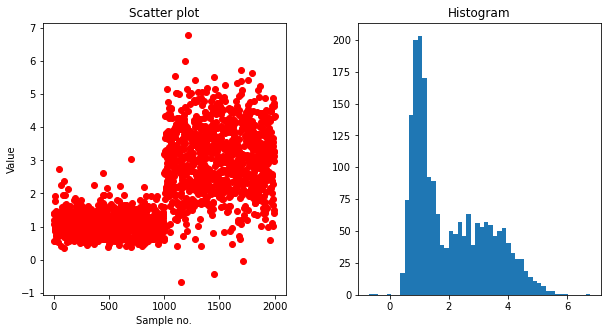

In [3]:
x_train = generate_data()[:, np.newaxis]
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
plt.subplot(121)
plt.scatter(np.arange(len(x_train)), x_train, c='red')
plt.xlabel('Sample no.')
plt.ylabel('Value')
plt.title('Scatter plot')
plt.subplot(122)
plt.hist(x_train, bins=50)
plt.title('Histogram')
fig.subplots_adjust(wspace=.3)
plt.show()

Fitting a KDE object

Now we will create a KernelDensity object and use the fit() method to find the score of each sample as shown in the code below. The KernelDensity() method uses two default parameters, i.e. kernel=gaussian and bandwidth=1.

In [5]:
model = KernelDensity()
model.fit(x_train)
x_test = np.linspace(-1, 7, 2000)[:, np.newaxis]
log_dens = model.score_samples(x_test)

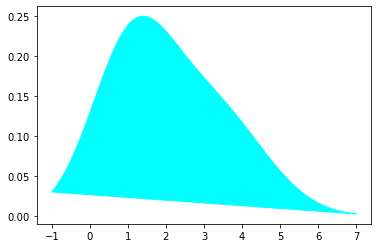

In [6]:
plt.fill(x_test, np.exp(log_dens), c='cyan')
plt.show()

Experimenting with different values of bandwidth to see how it affects density estimation

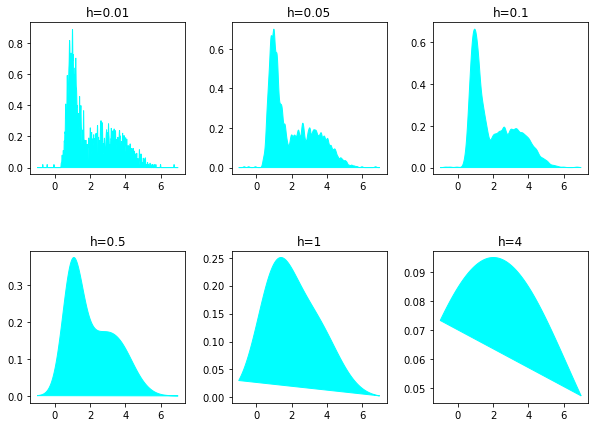

In [7]:
bandwidths = [0.01, 0.05, 0.1, 0.5, 1, 4]
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 7))
plt_ind = np.arange(6) + 231

for b, ind in zip(bandwidths, plt_ind):
    kde_model = KernelDensity(kernel='gaussian', bandwidth=b)
    kde_model.fit(x_train)
    score = kde_model.score_samples(x_test)
    plt.subplot(ind)
    plt.fill(x_test, np.exp(score), c='cyan')
    plt.title("h="+str(b))

fig.subplots_adjust(hspace=0.5, wspace=.3)
plt.show()

Tuning the Bandwidth Parameter

The scikit-learn library allows the tuning of the bandwidth parameter via cross-validation and returns the parameter value that maximizes the log-likelihood of data. The function we can use to achieve this is GridSearchCV(), which requires different values of the bandwidth parameter.

In [8]:
bandwidth = np.arange(0.05, 2, .05)
kde = KernelDensity(kernel='gaussian')
grid = GridSearchCV(kde, {'bandwidth': bandwidth})
grid.fit(x_train)

GridSearchCV(estimator=KernelDensity(),
             param_grid={'bandwidth': array([0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05, 1.1 ,
       1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 , 1.65,
       1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95])})

The best model can be retrieved by using the best_estimator_ field of the GridSearchCV object.

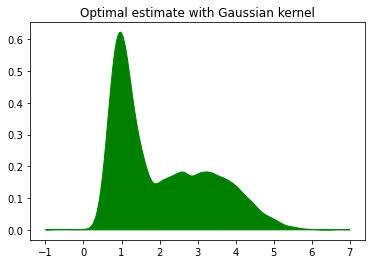

optimal bandwidth: 0.15


In [9]:
kde = grid.best_estimator_
log_dens = kde.score_samples(x_test)
plt.fill(x_test, np.exp(log_dens), c='green')
plt.title('Optimal estimate with Gaussian kernel')
plt.show()
print("optimal bandwidth: " + "{:.2f}".format(kde.bandwidth))

#### Different Kernels for Density Estimation

In [ ]:
def my_scores(estimator, X):
    scores = estimator.score_samples(X)
    # Remove -inf
    scores = scores[scores != float('-inf')]
    # Return the mean values
    return np.mean(scores)

kernels = ['cosine', 'epanechnikov', 'exponential', 'gaussian', 'linear', 'tophat']
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 7))
plt_ind = np.arange(6) + 231
h_vals = np.arange(0.05, 1, .1)

for k, ind in zip(kernels, plt_ind):
    grid = GridSearchCV(KernelDensity(kernel=k),
                        {'bandwidth': h_vals},
                        scoring=my_scores)
    grid.fit(x_train)
    kde = grid.best_estimator_
    log_dens = kde.score_samples(x_test)
    plt.subplot(ind)
    plt.fill(x_test, np.exp(log_dens), c='cyan')
    plt.title(k + " h=" + "{:.2f}".format(kde.bandwidth))

fig.subplots_adjust(hspace=.5, wspace=.3)
plt.show()

In [ ]:
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': h_vals, 'kernel': kernels},
                    scoring=my_scores)
grid.fit(x_train)
best_kde = grid.best_estimator_
log_dens = best_kde.score_samples(x_test)
plt.fill(x_test, np.exp(log_dens), c='green')
plt.title("Best Kernel: " + best_kde.kernel+" h="+"{:.2f}".format(best_kde.bandwidth))
plt.show()

#### Drawing samples with Monte Carlo simulation and compare the stats of the 2 samples (kde_scores on test and monte carlo simuation)

In [10]:
from scipy.integrate import quad
# Mean and Variance - Integration
pdf = lambda x : np.exp(kde.score_samples([[x]]))[0]
mean_integration = quad(lambda x: x * pdf(x), a=-np.inf, b=np.inf)[0]
variance_integration = quad(lambda x: (x ** 2) * pdf(x), a=-np.inf, b=np.inf)[0] - mean_integration ** 2

# Mean and Variance - Monte Carlo
n_samples = 10000000
samples = kde.sample(n_samples)

mean_mc = samples.mean()
variance_mc = samples.var()

In [11]:
print('Mean:\nIntegration: {}\nMonte Carlo: {}\n'.format(mean_integration, mean_mc))
print('Variance\nIntegration: {}\nMonte Carlo: {}\n'.format(variance_integration, variance_mc))

Mean:
Integration: 2.0604475669398523
Monte Carlo: 2.060317202075975

Variance
Integration: 1.600266890566588
Monte Carlo: 1.6002852932199707



In [12]:
samples

array([[2.11863051],
       [1.44641923],
       [0.89390816],
       ...,
       [1.03428506],
       [2.42431997],
       [0.96123375]])

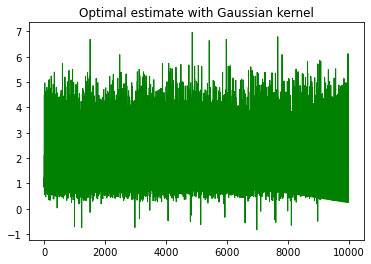

In [25]:
import matplotlib.pyplot as plt
plt.rcParams['agg.path.chunksize'] = 1000
plt.fill(samples[::1000], c='green')
plt.title('Optimal estimate with Gaussian kernel')
plt.show()

well known problem of statistics: we want to collect information about a population, but we are provided only with a sample of this population. How can we be sure that this sample is representative of the whole population? Namely, if we compute the mean of our sample, does it well approximate the true mean of the population?

Moreover, we have to consider that, besides the statistics of means, standard deviations, Pearson coefficients etc., in a non-parametric framework the cumulative distribution function (CDF) is itself unknown, hence it automatically becomes one of the parameter to infer from our sample.

So, the idea of Bootstrap is that, instead of estimating our statistic only once, on the sample realization we obtained, we can do it many times on a re-sampling (with replacement) of the original sample. With this approach, repeated B times, we will obtain a vector of estimates of length B, of which we can compute the expected value, variance, empirical distribution and so forth.

https://datasciencechalktalk.com/2019/11/12/bootstrap-sampling-an-implementation-with-python/

In [27]:
sample_mean = []
for _ in range(10000):  #so B=10000
    sample_n = kde.sample(300)
    #sample_n = np.random.choice(sample, size=300)
    sample_mean.append(sample_n.mean())

(array([1.000e+01, 7.200e+01, 5.540e+02, 1.912e+03, 3.083e+03, 2.796e+03,
        1.234e+03, 2.950e+02, 4.100e+01, 3.000e+00]),
 array([1.76799875, 1.82894506, 1.88989137, 1.95083768, 2.01178399,
        2.0727303 , 2.13367662, 2.19462293, 2.25556924, 2.31651555,
        2.37746186]),
 <a list of 10 Patch objects>)

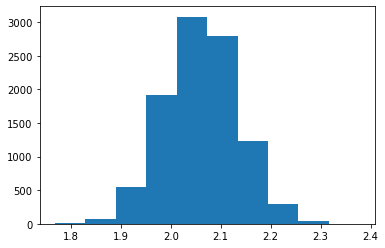

In [28]:
plt.hist(sample_mean)


#### Mean value of sample vaules of Bootstraping Sampling

In [30]:
np.mean(sample_mean)

2.060732539570797

#### Mean value of sample vaules of KDE

In [31]:
mean_integration

2.0604475669398523

#### Mean value of sample vaules of Monte Carlo Simulation

In [35]:
mean_mc = samples.mean()
mean_mc

2.060317202075975